# Augmenting images

In [74]:
# Import required packages
import pandas as pd
import numpy as np
import torch
import torchvision
import PIL
import os
import re
import imageio
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from imgaug import BoundingBoxesOnImage
from skimage.io import imsave

### Define helper function to return annotation information

In [12]:
# define useful file paths:
image_directory = '/workspaces/breast-tumor-detection/Data/'
annotation_path = '/workspaces/breast-tumor-detection/Preprocessing/Annotation_Boxes.xlsx'
mapping_path = '/workspaces/breast-tumor-detection/Preprocessing/Breast-Cancer-MRI-filepath_filename-mapping.xlsx'

#### Function to get annotation information for each image

In [49]:
# Get annotation dataset
annotation = pd.read_excel(annotation_path)
annotation['ID_Number'] = annotation['Patient ID'].apply(lambda x: x.split('_')[-1])
annotation = annotation.set_index("ID_Number")

def extract_annotation(annotation, class_folder, image_path):
    # Extract the patient ID
    patient_id = image_path.split('.')[0][-3:]

    # Get the start, end row and column
    (start_r,
    end_r,
    start_c,
    end_c) = (
        annotation.loc[patient_id, 'Start Row'],
        annotation.loc[patient_id, 'End Row'],
        annotation.loc[patient_id, 'Start Column'],
        annotation.loc[patient_id, 'End Column']
    )

    # Calculate w, h
    w = end_c - start_c
    h = end_r - start_r

    # Return the extracted attributes
    return image_path, class_folder, patient_id, start_r, start_c, end_r, end_c, w, h


#### Function to convert the annotation dataframe into the csv

In [50]:
# Function to convert annotation file into csv
def annotation_to_csv(annotation, image_directory, classes_folders):
  # List containing all our attributes regarding each image
  annot_list = []
  
  # We loop our each class and its labels one by one to preprocess and augment 
  for class_folder in classes_folders:
    # Set our images and annotations directory
    image_dir = os.path.join(image_directory, class_folder)
    # Get each file in the image and annotation directory
    img_files = os.listdir(image_dir)
    # Loop over each of the image and its label
    for image_file in img_files:
      # Get Attributes for each image 
      value = extract_annotation(annotation, class_folder, image_file) 
      # Append the attributes to the mat_list
      annot_list.append(value)
 
  # Columns for Pandas DataFrame
  column_name = ['filename', 'class', 'patient_id', 'xmin', 'ymin', 'xmax', 
                 'ymax', 'width', 'height']
 
  # Create the DataFrame from annot_list
  df = pd.DataFrame(annot_list, columns=column_name)
 
  # Return the dataframe
  return df
 
# The Classes we will use for our training
classes_list = ['pos',  'neg']
# Run the function to convert all the MAT files to a Pandas DataFrame
labels_df = annotation_to_csv(annotation, image_directory, classes_list)

#### Function to augment image data

In [39]:
# Define all the Augmentations you want to apply to your dataset
# We're setting random `n` agumentations to 2. 
image_augmentations = iaa.SomeOf(3,
    [                                 
    # Scale the Images
    iaa.Affine(scale=(0.5, 1.5)),
 
    # Rotate the Images
    iaa.Affine(rotate=(-60, 60)),
 
    # Shift the Image
    iaa.Affine(translate_percent={"x":(-0.3, 0.3),"y":(-0.3, 0.3)}),
 
    # Flip the Image
    iaa.Fliplr(1),
 
    # Increase or decrease the brightness
    iaa.Multiply((0.5, 1.5)),
 
    # Add Gaussian Blur
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
     
    # Add Gaussian Noise
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))
 
])

In [75]:
# Function to convert bounding box image into DataFrame 
def bounding_boxes_to_df(bounding_boxes_object):
 
    # Convert Bounding Boxes Object to Array
    bounding_boxes_array = bounding_boxes_object.to_xyxy_array()
     
    # Convert the array into DataFrame
    df_bounding_boxes = pd.DataFrame(bounding_boxes_array,columns=['xmin', 'ymin', 'xmax', 'ymax'])
     
    # Return the DataFrame
    return df_bounding_boxes

In [81]:
labels_df

,filename,class,patient_id,xmin,ymin,xmax,ymax,width,height
0,1-130-BreastMRI038.png,pos,038,255,370,291,410,40,36
1,1-102-BreastMRI003.png,pos,003,351,82,412,139,57,61
2,1-104-BreastMRI223.png,pos,223,116,319,138,344,25,22
3,1-124-BreastMRI060.png,pos,060,220,364,271,413,49,51
4,1-083-BreastMRI215.png,pos,215,301,324,316,341,17,15
...,...,...,...,...,...,...,...,...,...
299,1-089-BreastMRI204.png,pos,204,87,64,101,74,10,14
300,1-072-BreastMRI240.png,pos,240,256,386,324,414,28,68
301,1-107-BreastMRI085.png,pos,085,160,105,187,135,30,27
302,1-090-BreastMRI094.png,pos,094,42,61,107,114,53,65


In [103]:
def image_aug(df, images_path, aug_images_path, augmentor, multiple = 3):
     
    # Fill this DataFrame with image attributes
    augmentations_df = pd.DataFrame(
        columns=['filename','class','patient_id','xmin', 'ymin', 'xmas', 'ymax','width', 'height'])
     
    # Group the data by filenames
    grouped_df = df.groupby('filename')
 
    # Create the directory for all augmentated images
    if not os.path.exists(aug_images_path):
      os.mkdir(aug_images_path)
 
    # Create directories for each class of augmentated images
    for folder in df['class'].unique():
        for i in range(multiple):
            augmented_folder = 'Augmentation_'+str(i)
            if not os.path.exists(os.path.join(aug_images_path, folder, augmented_folder)):
                os.mkdir(os.path.join(aug_images_path, folder, augmented_folder))

            # Suffix we add to the each different augmentation of one image
            image_suffix = str(i)

            # Loop to perform the augmentations
            for filename in df['filename'].unique():
                # Get patient id
                patient_id = filename.split('.')[0][-3:]
                # Augmented file name
                augmented_filename = 'BreastMRI'+patient_id+'-aug'+image_suffix+'.png'
                # Define path of storing augmented data
                augmented_path = os.path.join(aug_images_path, folder, augmented_folder, augmented_filename)
        
                # Take one image at a time with its information
                single_image = grouped_df.get_group(filename)
                single_image = single_image.reset_index()
                single_image = single_image.drop(['index'], axis=1)   
                
                # Read the image
                image = imageio.v2.imread(os.path.join(images_path, folder, filename))
        
                # Get bounding box
                bounding_box_array = single_image.drop(['filename', 'width', 'height','class','patient_id'], axis=1).values
        
                # Give the bounding box to imgaug library
                bounding_box = BoundingBoxesOnImage.from_xyxy_array(bounding_box_array, shape=image.shape)
        
                # Perform random 2 Augmentations
                image_aug, bounding_box_aug = augmentor(image=image,bounding_boxes=bounding_box)
                
                # Discard the the bounding box going out the image completely   
                bounding_box_aug = bounding_box_aug.remove_out_of_image()
        
                # Clip the bounding box that are only partially out of th image
                bounding_box_aug = bounding_box_aug.clip_out_of_image()
        
                # Get rid of the the image if bounding box was discarded  
                if re.findall('Image...', str(bounding_box_aug)) == ['Image([]']:
                    pass
                
                else:
                    # Create the augmented image file
                    imsave(augmented_path, image_aug) 
            
                    # Update the image width and height after augmentation
                    info_df = single_image.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
                    for index, _ in info_df.iterrows():
                        info_df.at[index, 'width'] = image_aug.shape[1]
                        info_df.at[index, 'height'] = image_aug.shape[0]
            
                    # Add suffix to each image to differentiate if required
                    info_df['filename'] = augmented_filename
             
                    # Create the augmented bounding boxes dataframe 
                    bounding_box_df = bounding_boxes_to_df(bounding_box_aug)
            
                    # Concatenate the filenames, height, width and bounding boxes 
                    aug_df = pd.concat([info_df, bounding_box_df], axis=1)
            
                    # Add all the information to augmentations_df we initialized above
                    augmentations_df = pd.concat([augmentations_df, aug_df])            
                
                # Remove index
                augmentations_df = augmentations_df.reset_index()
                augmentations_df = augmentations_df.drop(['index'], axis=1)
    
        # Return the Dataframe
        return augmentations_df

In [104]:
augmented_images_df = image_aug(labels_df, image_directory, '/workspaces/breast-tumor-detection/Augmented_Data/', 
                                image_augmentations)

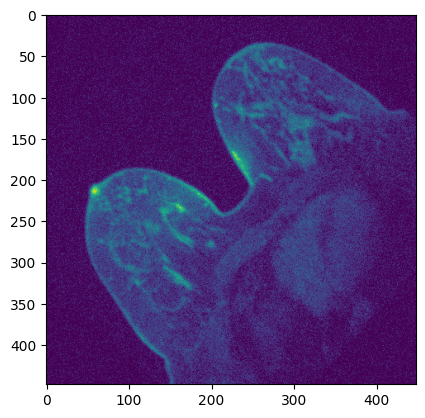

In [94]:
image = imageio.v2.imread('/workspaces/breast-tumor-detection/Augmented_Data/pos/BreastMRI001-aug0.png')
plt.imshow(image)